# Chapter8 어텐션

## 8.1 어텐션 구조

### 8.1.1 seq2seq의 문제점
- Encoder의 출력은 '고정 길이의 벡터'인데, 고정 길이 벡터는 입력 문장의 길이에 관계없이 항상 같은 길이의 벡터로 변환
- 이렇게 되면 필요한 정보가 벡터에 다 담기지 않음

### 8.1.2 Encoder 개선
- Encoder 출력의 길이를 입력 문장의 길이에 따라 바꿔주기
- Encoder가 출력하는 hs 행렬은 각 단어에 해당하는 벡터들의 집합
- keras RNN 계층의 초기화 인수 return_sequences=True : 모든 시각의 은닉상태벡터를 반환

### 8.1.3 Decoder 개선1
- '입력과 출력의 여러 단어 중 어떤 단어끼리 서로 관련되어 있는가'라는 대응 관계
- 필요한 정보에만 주목하여 그 정보로부터 시계열 변환을 수행하는 것이 목표 = 어텐션
- 각 단어의 중요도(기여도)를 나타내는 '가중치'를 별도로 계산

In [1]:
import numpy as np

T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5, 1).repeat(4, axis=1)
print("ar.shape:", ar.shape)
print(ar)

t = hs * ar
print("t.shape:", t.shape)
print(t)

c = np.sum(t, axis=0)
print("c.shape:", c.shape)
print(c)

ar.shape: (5, 4)
[[0.8  0.8  0.8  0.8 ]
 [0.1  0.1  0.1  0.1 ]
 [0.03 0.03 0.03 0.03]
 [0.05 0.05 0.05 0.05]
 [0.02 0.02 0.02 0.02]]
t.shape: (5, 4)
[[ 0.92213466  0.07993642  1.29287305  0.07689452]
 [-0.10521151  0.20460277  0.02612539 -0.12710195]
 [-0.01691926  0.04252966  0.03065717  0.0320055 ]
 [-0.03366714 -0.11450667  0.0043201   0.02875747]
 [-0.00352427 -0.0051169   0.01249374 -0.00423493]]
c.shape: (4,)
[0.76281247 0.20744527 1.36646946 0.00632062]


In [2]:
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)
# ar = a.reshape(N, T, 1)   브로드캐스트사용

t = hs * ar
print("t.shape:", t.shape)
print(t)

c = np.sum(t, axis=1)
print("c.shape:", c.shape)
print(c)

t.shape: (10, 5, 4)
[[[-1.04365301e-01  3.46721366e-01 -1.25917344e+00  6.32272341e-01]
  [ 1.16635638e-01  1.62190188e-01 -3.31974348e-02  3.21264407e-01]
  [-7.85581009e-02  1.86633058e-02 -3.16135788e-02  2.59185062e-03]
  [-1.28428374e+00 -5.68648650e-02 -3.52974851e-02  3.61573273e+00]
  [ 4.57126053e-01  3.22427408e-01 -1.08428927e-01  4.66074483e-01]]

 [[ 1.42994299e-02 -2.48865276e-02  6.17457122e-02  4.90816363e-03]
  [-7.01841558e-02  3.40481054e-02 -8.59803326e-03  2.70145386e-02]
  [ 1.58392343e-02  4.04597238e-02 -8.56287271e-03 -2.88751200e-02]
  [ 7.26383568e-02  3.60468792e-01 -2.62714540e-01 -3.61423267e-01]
  [ 2.24731729e+00 -1.40432568e+00  2.02458719e-01  8.68408745e-01]]

 [[ 6.60921302e-01 -8.85002893e-02 -2.10294629e-01 -8.18820605e-01]
  [-3.91682368e-01 -6.26245052e-01 -1.03940004e-01 -4.45049267e-01]
  [ 1.90644731e-01 -2.96266806e-01  8.85724501e-01  8.90593485e-01]
  [-1.64211029e+00 -4.42388044e-01  3.23856967e+00  4.42868455e-01]
  [ 5.55492797e-01  3.59

In [3]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs*ar
        c = np.sum(t, axis=1)
        
        self.cache = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)   # sum의 역전파
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)   # repeat의 역전파
        
        return dhs, da

### 8.1.4 Decoder 개선2
- Decoder의 LSTM 계층의 은닉 상태 벡터를 h라고 하는데, h가 hs의 각 단어 벡터와 얼마나 비슷한가를 수치로 나타내기
- 내적 사용 = 두 벡터가 얼마나 같은 방향을 향하고 있는가 (유사도)
- h와 hs이 각 단어 벡터와의 유사도 구한 후 s(score)를 구하고 softmax 함수 적용(정규화)

In [4]:
import sys
sys.path.append('..')
from common.layers import Softmax
import numpy as np

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)
# ar = a.reshape(N, T, 1)   브로드캐스트사용

t = hs * ar
print("t.shape:", t.shape)

s = np.sum(t, axis=1)
print("s.shape:", s.shape)

softmax = Softmax()
a = softmax.forward(s)
print("a.shape:", a.shape)

t.shape: (10, 5, 4)
s.shape: (10, 4)
a.shape: (10, 4)


In [5]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Softmax

class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)     #.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

### 8.1.5 Decoder 개선3
- Attention Weight과 Weight Sum 결합
- Attention Weight 계층: Encoder가 출력하는 각 단어의 벡터 hs에 주목하여 해당 단어의 가중치 a를 구함
- Weight Sum 계층: a와 hs의 가중합을 구하고 그 결과를 맥락 벡터 c로 출력

In [6]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Softmax

class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

In [7]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Softmax

class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

## 8.2 어텐션을 갖춘 seq2seq 구현

### 8.2.1 Encoder 구현

In [8]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.seq2seq import Encoder, Seq2seq
from common.attention_layer import TimeAttention

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### 8.2.2 Decoder 구현

In [9]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.seq2seq import Encoder, Seq2seq
from common.attention_layer import TimeAttention

class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

### 8.2.3 seq2seq 구현

In [10]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.seq2seq import Encoder, Seq2seq
from common.attention_layer import TimeAttention

class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## 8.3 어텐션 평가

### 8.3.1 날짜 형식 변환 문제
- dataset/date.txt

### 8.3.2 어텐션을 갖춘 seq2seq의 학습

| epoch 1 |  iter 1 / 351 | time 1[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 20[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 43[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 64[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 84[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 104[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 125[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 145[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 165[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 186[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 207[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 228[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 249[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 269[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 290[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 310[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 330[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 349[s] | loss 1.00
Q 10/15/94                     
T 1994-1

Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
정확도 99.920%
| epoch 6 |  iter 1 / 351 | time 1[s] | loss 0.00
| epoch 6 |  iter 21 / 351 | time 22[s] | loss 0.00
| epoch 6 |  iter 41 / 351 | time 43[s] | loss 0.00
| epoch 6 |  iter 61 / 351 | time 64[s] | loss 0.00
| epoch 6 |  iter 81 / 351 | time 85[s] | loss 0.00
| epoch 6 |  iter 101 / 351 | time 105[s] | loss 0.00
| epoch 6 |  iter 121 / 351 | time 126[s] | loss 0.00
| epoch 6 |  iter 141 / 351 | time 147[s] | loss 0.00
| epoch 6 |  iter 161 / 351 | time 168[s] | loss 0.00
| epoch 6 |  iter 181 / 351 | time 188[s] | loss 0.00
| epoch 6 |  iter 201 / 351 | time 209[s] | loss 0.00
| epoch 6 |  iter 221 / 351 | time 230[s] | loss 0.00
| epoch 6 |  iter 241 / 351 | time 251[s] | loss 0.00
| epoch 6 |  iter 261 / 351 | time 272[s] | loss 0.00
| epoch 6 |  iter 281 / 351 | time 292[s] | loss 0.00
| epoch 6 |  iter 301 / 351 | time 313[s] | loss 0.00
| epoch 6 |  iter 321 / 351 | time 334[s] | loss 0.00
| epoch 6 |  iter 34

Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
정확도 100.000%


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_

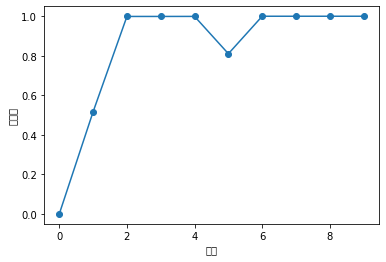

In [12]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from common.attention_seq2seq import AttentionSeq2seq
from common.seq2seq import Seq2seq
from common.peeky_seq2seq import PeekySeq2seq


# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))


model.save_params()

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

### 8.3.3 어텐션 시각화
- common.visualize_attention

## 8.4 어텐션에 관한 남은 이야기

### 8.4.1 양방향 RNN
- LSTM 계층에 더해 역방향으로 처리하는 LSTM 게층 추가
- 각 시각에서는 이 두 LSTM 계층의 은닉 상태를 연결시킨 벡터를 최종 은닉 상태로 처리
- 양방향으로 처리함으로써 각 단어에 대응하는 은닉 상태 벡터에는 좌와 우 양쪽 방향으로부터 정보 집약
- 따라서 균형 잡힌 정보 인코딩

### 8.4.2 Attention 계층 사용 방법

### 8.4.3 seq2seq 심층화와 skip 연결
- RNN 계층을 깊게 쌓기, 층을 깊게 쌓으면 표현력 높은 모델을 만들 수 있다
- skip 연결 : 계층을 넘어 선을 연결
- 따라서 층이 깊어져도 기울기 소실, 폭발되지 않고 전파됨

## 8.5 어텐션 응용

### 8.5.1 구글 신경망 기계 번역 (GNMT)
- 신경망 기계 번역 Neural Machine Translation

### 8.5.2 트랜스포머
- 'RNN이 아닌' 어텐션 사용
- 셀프어텐션 self-attention : 하나의 시계열 데이터 내에서 각 원소가 다른 원소들과 어떻게 관련되는지 살펴보기

### 8.5.3 뉴럴 튜링 머신 (NTM)
- 외부 메모리를 통한 확장
- Encoder와 Decoder는 '메모리 조작' 같은 작업을 수행
- RNN의 외부에 정보 저장용 메모리 기능을 배치하고 어텐션을 이용하여 그 메모리로부터 필요한 정보를 읽거나 쓰는 방법